In [21]:
import nibabel as nib
import numpy as np
from skimage import morphology, measure
from scipy.ndimage import binary_closing, binary_opening
import os
import SimpleITK as sitk
from scipy.ndimage import binary_dilation


Volume shape: (512, 512, 216)


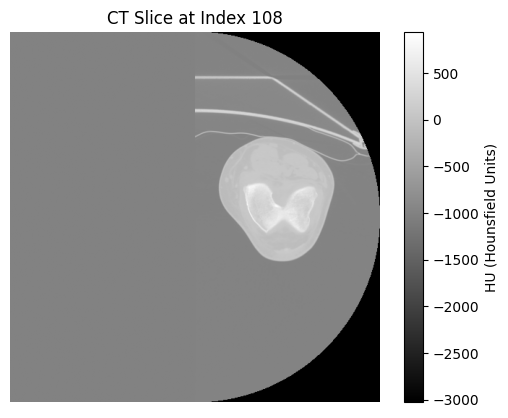

In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Load the CT scan
nifti_img = nib.load('../left_knee.nii.gz')  # replace with actual path
volume = nifti_img.get_fdata()

print("Volume shape:", volume.shape)

# Choose a middle slice along one axis (typically axial slices)
slice_index = volume.shape[2] // 2
slice_img = volume[:, :, slice_index]

# Display the slice
plt.imshow(slice_img.T, cmap='gray', origin='lower')
plt.title(f'CT Slice at Index {slice_index}')
plt.axis('off')
plt.colorbar(label='HU (Hounsfield Units)')
plt.show()

In [3]:
def load_nii(path):
    """Loads a NIfTI image and returns image data and affine matrix"""
    img = nib.load(path)
    return img.get_fdata(), img.affine, img.header

In [4]:
def save_nii(data, affine, header, path):
    """Saves image data to a NIfTI file"""
    nib.save(nib.Nifti1Image(data.astype(np.uint8), affine, header), path)


In [5]:
def segment_bone(ct_volume, threshold=300):
    """
    Segments bone based on intensity thresholding.
    Typical CT Hounsfield values: bone > 300 HU
    """
    bone_mask = ct_volume > threshold  # bone = high intensity
    bone_mask = morphology.remove_small_objects(bone_mask.astype(bool), min_size=1000)
    bone_mask = morphology.remove_small_holes(bone_mask, area_threshold=1000)
    return bone_mask.astype(np.uint8)

In [6]:
def keep_largest_components(mask, num_components=2):
    """Keeps the largest N connected components — expected femur & tibia"""
    labeled = measure.label(mask)
    props = measure.regionprops(labeled)
    props = sorted(props, key=lambda x: x.area, reverse=True)
    output_mask = np.zeros_like(mask)

    for i in range(min(num_components, len(props))):
        output_mask[labeled == props[i].label] = 1

    return output_mask

In [8]:
if __name__ == "__main__":
    # Step 1: Load CT scan
    input_path = "../left_knee.nii.gz" 
    ct_volume, affine, header = load_nii(input_path)

    # Step 2: Segment bone
    raw_bone_mask = segment_bone(ct_volume, threshold=300)

    # Step 3: Keep only femur & tibia
    final_bone_mask = keep_largest_components(raw_bone_mask, num_components=2)

    # Step 4: Save result
    os.makedirs("masks", exist_ok=True)
    output_path = "masks/original_mask.nii.gz"
    save_nii(final_bone_mask, affine, header, output_path)

    print("Segmentation complete. Mask saved at:", output_path)

Segmentation complete. Mask saved at: masks/original_mask.nii.gz


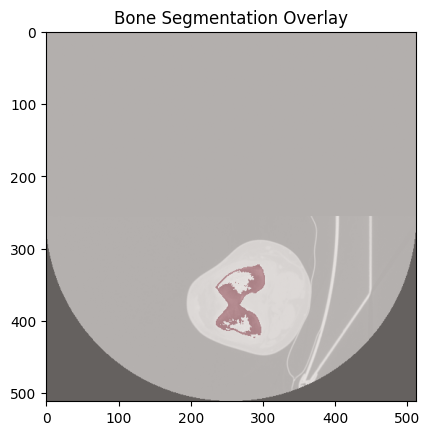

In [9]:
import matplotlib.pyplot as plt
plt.imshow(ct_volume[:, :, ct_volume.shape[2]//2], cmap='gray')
plt.imshow(final_bone_mask[:, :, ct_volume.shape[2]//2], alpha=0.4, cmap='Reds')
plt.title("Bone Segmentation Overlay")
plt.show()


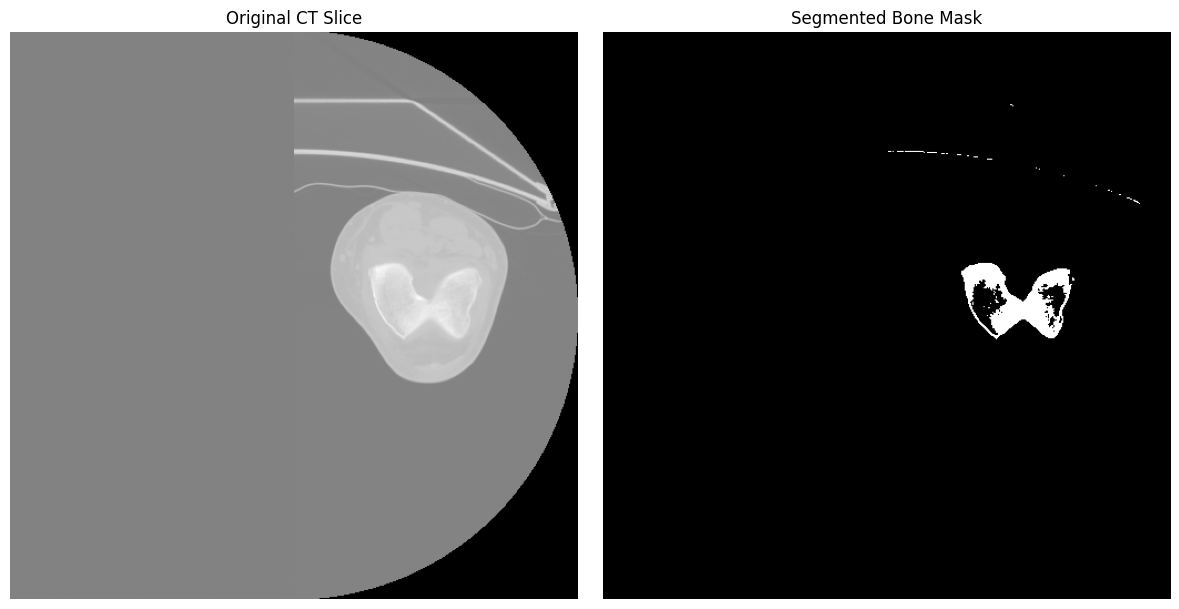

In [14]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Load the NIfTI file
img = nib.load('../left_knee.nii.gz')  # Replace with your actual file path
volume = img.get_fdata()

# Choose a slice number you want to analyze (e.g., middle slice)
slice_index = volume.shape[2] // 2  # You can adjust this

# Get the original slice
original_slice = volume[:, :, slice_index]

# Apply threshold to segment bone (HU > 300)
threshold = 300
segmented_slice = (original_slice > threshold).astype(np.uint8)

# Plot side by side
plt.figure(figsize=(12, 6))

# Original slice
plt.subplot(1, 2, 1)
plt.imshow(original_slice.T, cmap='gray', origin='lower')
plt.title('Original CT Slice')
plt.axis('off')

# Segmented slice
plt.subplot(1, 2, 2)
plt.imshow(segmented_slice.T, cmap='gray', origin='lower')
plt.title('Segmented Bone Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


In [15]:
# --- CONFIGURATION ---
CT_PATH = "../left_knee.nii.gz"
MASK_PATH = "masks/original_mask.nii.gz"
EXPANSION_MM = 2  # Parameter for expanding outward by N mm
RESULT_DIR = "results"
os.makedirs(RESULT_DIR, exist_ok=True)

In [16]:
def expand_mask(mask_array, spacing, expansion_mm):
    """
    Expands the mask uniformly by the specified distance in millimeters.
    
    Args:
        mask_array: The binary mask as a numpy array
        spacing: The voxel spacing (x, y, z) in mm
        expansion_mm: The expansion distance in mm
        
    Returns:
        The expanded binary mask
    """
    # Convert physical distance (mm) to voxel units, rounding up to ensure we meet the required expansion
    expansion_voxels = [
        max(1, int(np.ceil(expansion_mm / s))) for s in spacing[::-1]  # spacing[::-1] = (z, y, x)
    ]
    print(f"Expansion of {expansion_mm}mm converted to voxels: {expansion_voxels}")
    
    # Create a structuring element for binary dilation
    # The size is (2*expansion + 1) to create a symmetric element around the center
    structuring_element = np.ones(
        (2 * expansion_voxels[0] + 1, 2 * expansion_voxels[1] + 1, 2 * expansion_voxels[2] + 1),
        dtype=np.uint8
    )
    
    # Perform binary dilation to expand the mask
    expanded_mask = binary_dilation(mask_array, structure=structuring_element).astype(np.uint8)
    
    return expanded_mask

In [17]:
def main():
    # --- LOAD IMAGES ---
    print("Loading images...")
    ct_image = sitk.ReadImage(CT_PATH)
    mask_image = sitk.ReadImage(MASK_PATH)
    
    image_array = sitk.GetArrayFromImage(ct_image)
    original_mask = sitk.GetArrayFromImage(mask_image).astype(np.uint8)
    
    # --- GET VOXEL SPACING ---
    spacing = ct_image.GetSpacing()  # (x, y, z)
    print("Voxel spacing (mm):", spacing)
    
    # --- PERFORM EXPANSION ---
    print(f"Expanding mask by {EXPANSION_MM}mm...")
    expanded_mask = expand_mask(original_mask, spacing, EXPANSION_MM)
    
    # --- SAVE EXPANDED MASK ---
    print("Saving expanded mask...")
    expanded_mask_sitk = sitk.GetImageFromArray(expanded_mask)
    expanded_mask_sitk.CopyInformation(mask_image)  # Copy metadata from original mask
    expanded_mask_output_path = os.path.join(RESULT_DIR, f"expanded_mask_{EXPANSION_MM}mm.nii.gz")
    sitk.WriteImage(expanded_mask_sitk, expanded_mask_output_path)
    print(f"Expanded mask saved to: {expanded_mask_output_path}")
    
    # --- LOCATE NONZERO SLICES FOR VISUALIZATION ---
    slices_with_mask = [i for i in range(expanded_mask.shape[0]) if np.any(expanded_mask[i])]
    print("Slices with expanded mask:", slices_with_mask)
    
    if not slices_with_mask:
        raise ValueError("Expanded mask is empty!")
    
    # Use center of relevant slices for visualization
    slice_index = slices_with_mask[len(slices_with_mask) // 2]
    print("Visualizing slice index:", slice_index)
    
    # --- PLOTTING ---
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original CT
    axs[0].imshow(image_array[slice_index], cmap="gray")
    axs[0].set_title("Original CT")
    axs[0].axis('off')
    
    # Original bone mask overlay
    axs[1].imshow(image_array[slice_index], cmap="gray")
    axs[1].imshow(original_mask[slice_index], cmap="Reds", alpha=0.4)
    axs[1].set_title("Original Bone Mask")
    axs[1].axis('off')
    
    # Expanded mask overlay
    axs[2].imshow(image_array[slice_index], cmap="gray")
    axs[2].imshow(expanded_mask[slice_index], cmap="Blues", alpha=0.4)
    axs[2].set_title(f"Expanded Mask ({EXPANSION_MM}mm)")
    axs[2].axis('off')
    
    # Save and show figure
    plt.tight_layout()
    fig_path = os.path.join(RESULT_DIR, f"mask_expansion_{EXPANSION_MM}mm.png")
    plt.savefig(fig_path, dpi=300)
    print(f"Visualization saved to: {fig_path}")
    plt.show()
    
    # --- ALSO SAVE OVERLAY COMPARISON ---
    # Create a figure to show before/after comparison
    plt.figure(figsize=(12, 10))
    plt.imshow(image_array[slice_index], cmap="gray")
    plt.imshow(original_mask[slice_index], cmap="Reds", alpha=0.3)
    plt.imshow(expanded_mask[slice_index], cmap="Blues", alpha=0.3)
    plt.title(f"Comparison: Original (Red) vs Expanded {EXPANSION_MM}mm (Blue)")
    plt.axis('off')
    
    # Save comparison figure
    comparison_path = os.path.join(RESULT_DIR, f"expansion_comparison_{EXPANSION_MM}mm.png")
    plt.savefig(comparison_path, dpi=300)
    print(f"Comparison visualization saved to: {comparison_path}")
    
    # Write a text file with details about the expansion
    with open(os.path.join(RESULT_DIR, "expansion_details.txt"), "w") as f:
        f.write(f"Mask Expansion Details:\n")
        f.write(f"----------------------\n")
        f.write(f"Input CT image: {CT_PATH}\n")
        f.write(f"Input mask: {MASK_PATH}\n")
        f.write(f"Expansion distance: {EXPANSION_MM} mm\n")
        f.write(f"Voxel spacing: {spacing}\n")
        f.write(f"Expansion in voxels (z,y,x): {[max(1, int(np.ceil(EXPANSION_MM / s))) for s in spacing[::-1]]}\n")
        f.write(f"Original mask voxel count: {np.sum(original_mask)}\n")
        f.write(f"Expanded mask voxel count: {np.sum(expanded_mask)}\n")
        f.write(f"Increase in voxels: {np.sum(expanded_mask) - np.sum(original_mask)}\n")
    
    print("Expansion details written to: expansion_details.txt")
    print("Task 1.2 completed successfully!")

Loading images...
Voxel spacing (mm): (0.8691409826278687, 0.8691409826278687, 2.0)
Expanding mask by 2mm...
Expansion of 2mm converted to voxels: [1, 3, 3]
Saving expanded mask...
Expanded mask saved to: results\expanded_mask_2mm.nii.gz
Slices with expanded mask: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,

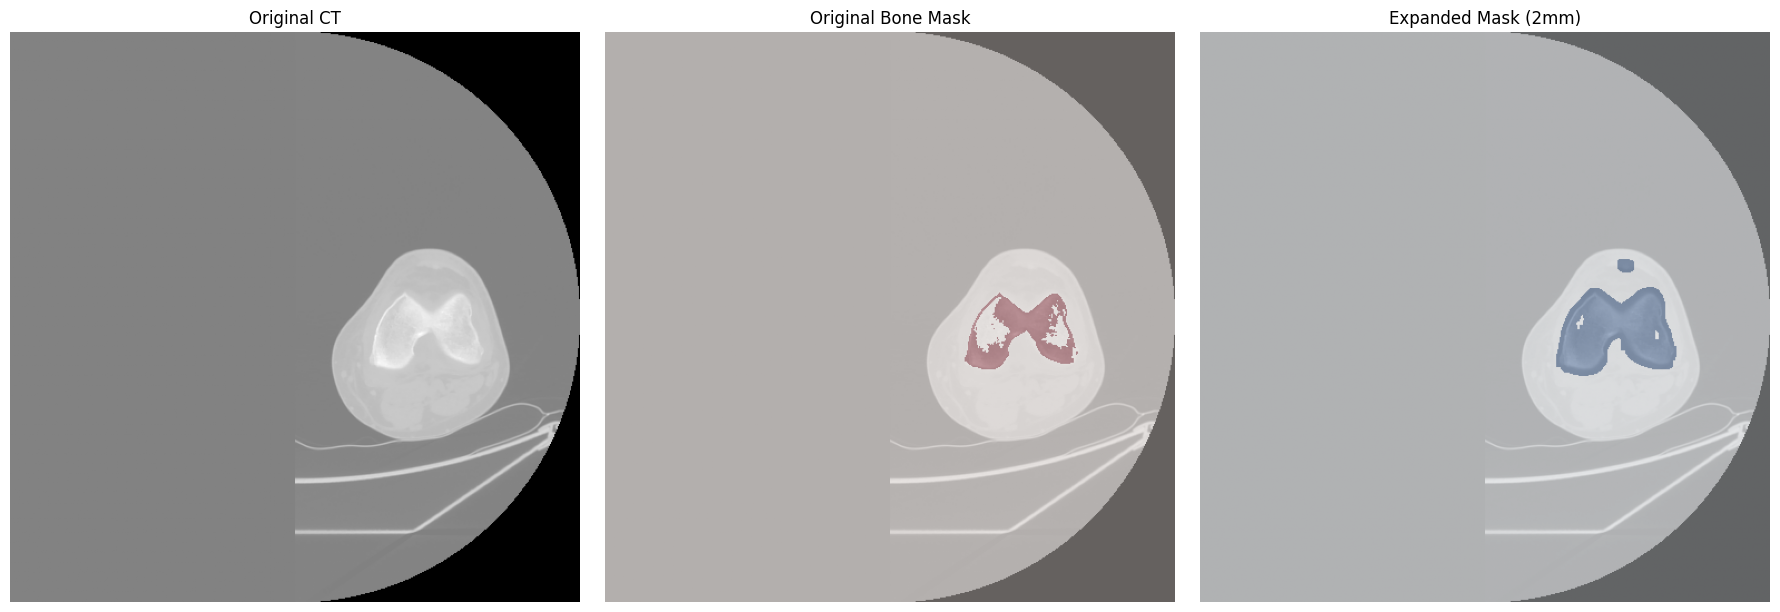

Comparison visualization saved to: results\expansion_comparison_2mm.png
Expansion details written to: expansion_details.txt
Task 1.2 completed successfully!


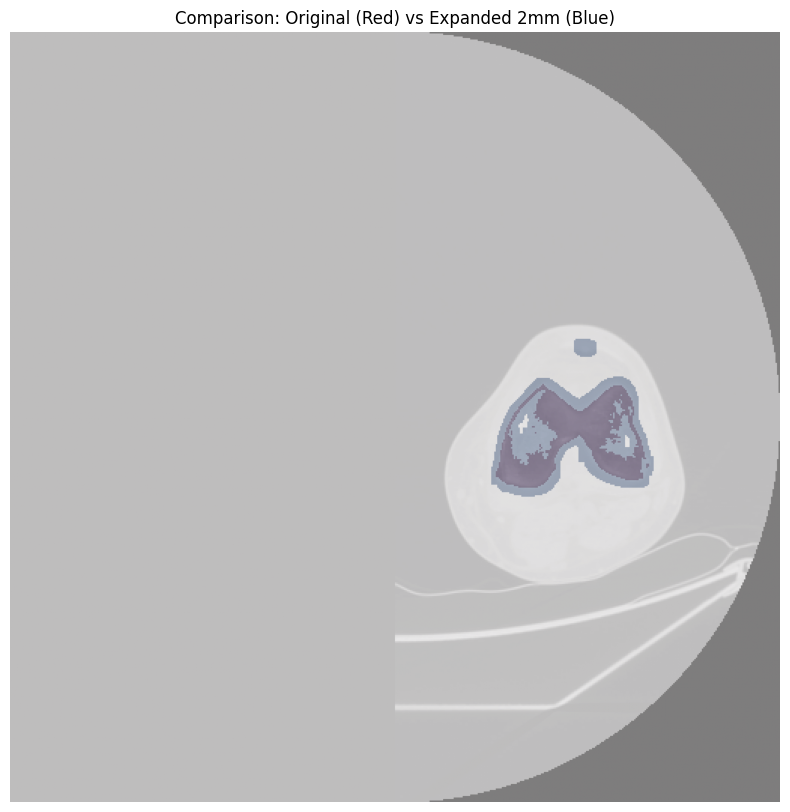

In [22]:
if __name__ == "__main__":
    main()